In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter
from scipy import signal
import math
from scipy.special import eval_chebyu

In [3]:
def import_data(file_loc, truncate=True, debug = False):
    captured_data = np.load(file_loc)
    input0_offset=np.argmax((captured_data[0]>0).astype(int))
    input1_offset=np.argmax((captured_data[1]>0).astype(int))
    output0_offset=np.argmax((captured_data[2]>0).astype(int))
    output1_offset=np.argmax((captured_data[3]>0).astype(int))
    
    # Truncate to 12 bits from 16, but store in 16 MSB aligned
    input0 = captured_data[0]
    input1 = captured_data[1]
    if(truncate):
        input0 = np.right_shift(input0,4)
        input0 = np.left_shift(input0,4).astype(np.int16)
        
        input1 = np.right_shift(input1,4)
        input1 = np.left_shift(input1,4).astype(np.int16)

    output0 = captured_data[2]
    output1 = captured_data[3]

    if(debug):
        print("input0_offset: %s"%(input0_offset))
        print("input1_offset: %s"%(input1_offset))
        print("output0_offset: %s"%(output0_offset))
        print("output1_offset: %s"%(output1_offset))

        print("input0_offset%%8: %s"%(input0_offset%8))
        print("input1_offset%%8: %s"%(input1_offset%8))
        print("output0_offset%%8: %s"%(output0_offset%8))
        print("output1_offset%%8: %s"%(output1_offset%8))

        print("input 0 first value: %s"%input0[input0_offset])
        print("input 1 first value: %s"%input1[input1_offset])
    
    return (input0, input1, output0, output1, input0_offset, input1_offset, output0_offset, output1_offset)

# Simulation

## Conversions and Utility

In [90]:
def bindigits(n, bits):
    """ https://stackoverflow.com/questions/12946116/twos-complement-binary-in-python
    Takes an integer value and number of bits, and converts to two's complement string
    Basically just masks off the number of bits. Python twos-complement are infinite length (...111111111101, for example)
    """
    s = bin(n & int("1"*bits, 2))[2:] # The [2:] cuts off the 0b of 0b######
    return ("{0:0>%s}" % (bits)).format(s)

def twos_complement_integer(n, bits):
    """ Returns two's complement representation of n as a <bits> bit number
    """
    return int(bindigits(n,bits),2)

def convert_to_fixed_point(a, a_int, a_frac, allow_overflow=False):
    """Converts to an integer with <a_frac> bits of of fractional representation, and <a_int> bits of integer
    i.e. Q<a_int>.<a_frac> (ARM)
    """
    if((a>=(2**(a_int-1)) or a<-1*(2**(a_int-1))) and not allow_overflow):
        raise Exception("Value %s out of bounds"%a)
    # Multiply fractional bits up to integers
    # Removing digits of a twos complement goes more negative, so we mimic that in advance
    a_temp = math.floor(a * (2**a_frac))

    if (a<0):
        # Convert to twos complement
        # print("Converting to twos complement")
        # print("%s = %s"%(a_temp, bin(a_temp)))
        a_temp = twos_complement_integer(a_temp, a_int+a_frac)
        # print("%s = %s"%(a_temp, bin(a_temp)))
        # print(bin(a_temp))
    a_temp = a_temp & int("1"*(a_int+a_frac), 2)
    return a_temp

def convert_from_fixed_point(a, a_int, a_frac, twos_complement=True):
    """Converts from a signed integer (Q<a_int>.<a_frac>, ARM) representation to a floating point
    """
    if(a<0):
        raise Exception("Expecting a to be respresented as an unsigned number")
    bits = a_int + a_frac
    
    if(twos_complement):
        if(a>=2**(bits+1)):
                raise Exception("Value %s out of bounds. Bits available: %s"%(a,bits+1))
        # If it is signed
        if (a & (1<<(bits-1))):
            # print("Signed")
            a = (-1*(1<<(bits)) + a)
    else:
        if(a>=(2**(bits)) or a<-1*(2**(bits))):
            raise Exception("Value %s out of bounds"%a)
    a_temp = (a / (2.0**a_frac))#%(2**a_int)
    
    return a_temp

In [91]:
initial = 0.12345
val = convert_to_fixed_point(initial, 4, 14)

val2 = convert_from_fixed_point(val, 4, 14)
print("%s => %s"%(initial,val2))

0.12345 => 0.1234130859375


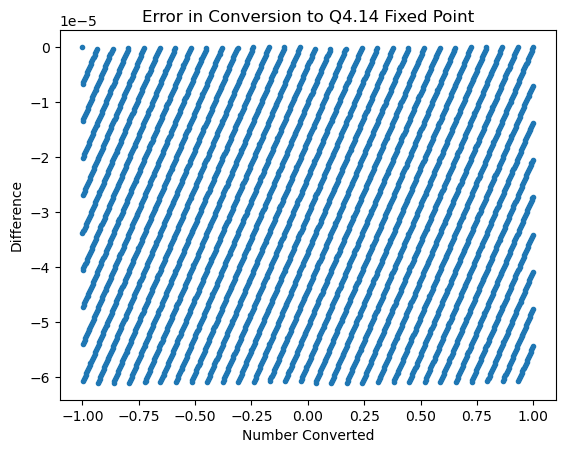

In [92]:
xs = np.linspace(-1,1,5000)
ys = [convert_from_fixed_point(convert_to_fixed_point(x,4,14),4,14) - x for x in xs]
plt.scatter(xs,ys, marker=".")
plt.title("Error in Conversion to Q4.14 Fixed Point")
plt.xlabel("Number Converted")
plt.ylabel("Difference")
plt.savefig("output.png")
plt.show()

In [95]:
def multiply(a, b, a_int, a_frac, b_int, b_frac, out_int, out_frac):
    """ We are assuming that the fixed point limits of the inputs are already followed.
    This means that normal multiplication is allowed if no error is thrown."""
    a = convert_to_fixed_point(a, a_int, a_frac)
    b = convert_to_fixed_point(b, b_int, b_frac)
    result_int = a * b
    return convert_from_fixed_point(result_int, out_int, out_frac, twos_complement=False)


In [96]:
a=5.5
a_int=4
a_frac=1
b=7
b_int=4
b_frac=0
multiply(a, b, a_int, a_frac, b_int, b_frac,16,1)

38.5

## Manual but not FPGA-style

In [97]:
def manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):

    
    for coeff_set in coeffs:
        for c in coeff_set:
            if(c >= 2**18 or c < -1*(2**18)):
                raise Exception("Coefficient out of bounds")
    
    x = np.array(x)
    y = np.zeros(len(x))
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(x)):
            total = 0
            for j in range(len(coeff_set)):
                c = convert_to_fixed_point(coeff_set[j], coeff_int, coeff_frac)
                x_point = convert_to_fixed_point(x[i-j], data_int, data_frac)
                total += c * x_point
            # get actual value after fixed point math
            y[i] = convert_from_fixed_point(total, coeff_int + data_int, coeff_frac+data_frac)
            # Reduce to precision of output. In the firmware overflow is clipped off
            val = convert_to_fixed_point(y[i], out_int, out_frac, allow_overflow=True)
            y[i] = convert_from_fixed_point(val, out_int, out_frac)
#             if(total>0):
#                 print(total)
#                 print(y[i])
        x=np.copy(y)
        y=np.zeros(len(x))
    return x

def manual_fir_pole_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):


    # Sneaky reuse, clean up later
    return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

    # For pole FIR
    #we get inputs in Q14.2 format. (NBITS-NFRAC, NFRAC)
    #Internally we compute in Q21.27 format, coefficients in Q4.14 format
    #So we shift to Q17.13 format.   
#     x = np.array(x)
#     y = np.zeros(len(x))
#     for coeff_set in coeffs:
#         for i in range(len(coeff_set), len(x)):
#             total = 0
#             for j in range(len(coeff_set)):
# #                 print(coeff_set[j])
#                 total += coeff_set[j] * x[i-j]
#             y[i] = total
#         x=np.copy(y)
#         y=np.zeros(len(x))
#     return x

def manual_fir_zero_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):
    # Each set of coefficients in the list is an FIR in series
    # This may need removed in the future
    
    # For zero FIR
    #coeffs in Q4.14
    #data in  Q18.12 and Q15.12
    #trim to  Q14.12 for the preadder
    #intermediate in Q22.26   
    
    # Sneaky reuse, clean up later
    return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

def manual_fir_section(coeffs, x):
    # Each set of coefficients in the list is an FIR in series
    # This may need removed in the future
    
    # For zero FIR
    #coeffs in Q4.14
    #data in  Q18.12 and Q15.12
    #trim to  Q14.12 for the preadder
    #intermediate in Q22.26   
    
    for coeff_set in coeffs:
        for c in coeff_set:
            if(c >= 2**18 or c < -1*(2**18)):
                raise Exception("Coefficient out of bounds")
    
    x = np.array(x)
    y = np.zeros(len(x))
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(x)):
            total = 0
            for j in range(len(coeff_set)):
                total += coeff_set[j] * x[i-j]
            y[i] = total#/(2**26)
#             if(total>0):
#                 print(total)
#                 print(y[i])
        x=np.copy(y)
        y=np.zeros(len(x))
    return x

def manual_fir_pole_section(coeffs, x):
    
    # Sneaky reuse, clean up later
    return manual_fir_section(coeffs, x)

def manual_fir_zero_section(coeffs, x):
    
    # Sneaky reuse, clean up later
    return manual_fir_section(coeffs, x)


def manual_iir_section(coeffs, y):
    y = np.array(y)
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(y)):
            total = coeff_set[0] * y[i]
            for j in range(1,len(coeff_set)):
#                 print(coeff_set[j])
                total -= coeff_set[j] * y[i-j]
            y[i] = total
    return y

## Clustered Look-ahead

In [98]:
def get_f_coeffs(samp_per_clock, mag, angle):
    f_fir = [0]*(samp_per_clock-2)
    for i in range(0, samp_per_clock-2):
        f_fir[i] = pow(mag, i)*eval_chebyu(i,np.cos(angle) )
    return f_fir

In [99]:
def get_g_coeffs(samp_per_clock, mag, angle):
    g_fir = [0]*(samp_per_clock-1)
    for i in range(0, samp_per_clock-1):
        g_fir[i] = pow(mag, i)*eval_chebyu(i,np.cos(angle) )
    return g_fir

In [100]:
def get_F_G_coefficients(samp_per_clock, mag, angle):
    D_FF = -1*pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock-2, np.cos(angle)) #L -alpha
    E_GG =  pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock, np.cos(angle)) #L delta

    # Crosslink coefficients. 
    D_FG = pow(mag, samp_per_clock-1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L beta
    # Lucas note - This was changed to add a negative sign, better matching the paper
    E_GF = -1*pow(mag, samp_per_clock+1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L -gamma
    return np.array([D_FF, D_FG, E_GF, E_GG])

In [101]:
# Adapted from https://github.com/barawn/pueo-dsp-python/tree/main/dsp. It is not tracked because I don't want to set up a submodule right now
def iir_biquad_coeffs(mag, angle, samp_per_clock=8):
    # Calculate the f and g fir coefficients, using the angle of the notch, the samples
    f_fir = get_f_coeffs(samp_per_clock, mag, angle)
    g_fir = get_g_coeffs(samp_per_clock, mag, angle)

    # Now we need to compute the F and G functions, which *again* are just FIRs,
    # however they're cross-linked, so it's a little trickier.
    # We split it into
    # F = (fir on f) + G_coeff*g(previous clock)
    # G = (fir on g) + F_coeff*f(previous clock)

    D_FF, D_FG, E_GF, E_GG = get_F_G_coefficients(samp_per_clock, mag, angle)

    # IIR parameters. See the 'update step' in paper.
    C = np.zeros(4)
    C[0] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock-2, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    C[1] = pow(mag, 2*samp_per_clock-1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock,np.cos(angle)) -
                                          eval_chebyu(samp_per_clock-2, np.cos(angle))))

    C[2] = pow(mag, 2*samp_per_clock+1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock-2, np.cos(angle))-
                                          eval_chebyu(samp_per_clock, np.cos(angle))))

    C[3] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    coeffs = np.zeros(2*samp_per_clock-3 + 4 + 4)
    coeffs[0:samp_per_clock-2] = np.array(f_fir)
    coeffs[samp_per_clock-2:2*samp_per_clock-3] = np.array(g_fir)
    coeffs[2*samp_per_clock-3:2*samp_per_clock-3 + 4] = get_F_G_coefficients(samp_per_clock, mag, angle)
    coeffs[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4] = C
    
    return coeffs

In [120]:
def iir_biquad_run(ins, coeffs, samp_per_clock=8, ics=None, manual_filter=False):
    if ics is None:
        # Debugging
        print("No initial conditions!")
        ics = np.zeros(samp_per_clock*3)
        ics = ics.reshape(3,-1)
    ins = np.array(ins)
    # Expand the inputs with the initial conditions
    newins = np.concatenate( (ics[0],ins) )

    f_fir = coeffs[0:samp_per_clock-2]
    g_fir = coeffs[samp_per_clock-2:2*samp_per_clock-3]
    D_FF = coeffs[2*samp_per_clock-3 + 0]
    D_FG = coeffs[2*samp_per_clock-3 + 1]
    E_GF = coeffs[2*samp_per_clock-3 + 2]
    E_GG = coeffs[2*samp_per_clock-3 + 3]
    C = coeffs[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4]

    # Run the FIRs
    if(manual_filter):
        raise Exception("Not implemented yet")
    else:
        f = signal.lfilter( f_fir, [1], newins )
        g = signal.lfilter( g_fir, [1], newins )
        # Now we decimate f/g by 8, because we only want the 0th and 1st samples out of 8 for each.
    
    f = f.reshape(-1, samp_per_clock).transpose()[0]
    g = g.reshape(-1, samp_per_clock).transpose()[1]
    
    # n.b. f[0]/g[0] are initial conditions

    # Lucas note: I think this should be f[1] and g[1]
    # f[2] (real sample 8) is calculated from 8, 7, 6, 5, 4, 3, 2.
    # g[2] (real sample 9) is calculated from 9, 8, 7, 6, 5, 4, 3, 2.

    # Now we need to compute the F and G functions, which *again* are just FIRs,
    # however they're cross-linked, so it's a little trickier.
    # We split it into
    # F = (fir on f) + G_coeff*g(previous clock)
    # G = (fir on g) + F_coeff*f(previous clock)
    
    F_fir = [ 1.0, D_FF ] # This is for sample 0
    G_fir = [ 1.0, E_GG ] # This is for sample 1

    # Debugging
    print("F/G FIRs operate on f/g inputs respectively")
    print("D_FF:", D_FF, " D_FG:", D_FG)
    print("E_GG:", E_GG, " E_GF:", E_GF)
    print()
    
    # print("F/G FIRs operate on f/g inputs respectively")
    # print("F FIR:", F_fir, "+g*", D_FG)
    # print("G FIR:", G_fir, "-f*", E_GF)
    # print()
    # print("As full FIRs calculated only for sample 0 and 1 respectively:")
    # print("F = f + (fz^-", samp_per_clock, ")+",Coeff_g_in_F,"*(gz^-", samp_per_clock-1, ")",sep='')
    # print("G = g + (gz^-", samp_per_clock, ")+",Coeff_f_in_G,"*(fz^-", samp_per_clock+1, ")",sep='')
        
    # Filter them
    F = signal.lfilter( F_fir, [1], f )
    G = signal.lfilter( G_fir, [1], g )

    # Now we need to feed the f/g paths into the opposite filter
    # F[0]/G[0] are going to be dropped anyway.
    F[1:] += D_FG*g[0:-1]
    G[1:] += E_GF*f[0:-1]    

    # drop the initial conditions
    F = F[1:]
    G = G[1:]
    
    # Now reshape our outputs.
    arr = ins.reshape(-1, samp_per_clock).transpose()
    # arr[0] is now every 0th sample (e.g. for samp_per_clock = 8, it's 0, 8, 16, 24, etc.)
    # arr[1] is now every 1st sample (e.g. for samp_per_clock = 8, it's 1, 9, 17, 25, etc.)
    # Debugging
    print("Update step (matrix) coefficients:", C)
    print("As an IIR: (Lucas thinks there is a typo here)")
    print("y[0] =", C[1], "*z^-", samp_per_clock*2-1," + ", C[0], "*z^-", samp_per_clock*2,
          "+F[0]",sep='')
    print("y[1] =", C[3], "*z^-", samp_per_clock*2," + ", C[2], "*z^-", samp_per_clock*2+1,
          "+G[1]",sep='')
    # Now compute the IIR.
    # INITIAL CONDITIONS STEP
    y0_0 =  C[0]*ics[1][0] + C[1]*ics[1][1] + F[0]
    y1_0 =  C[2]*ics[1][0] + C[3]*ics[1][1] + G[0]
    y0_1 =  C[0]*ics[2][0] + C[1]*ics[2][1] + F[1]
    y1_1 =  C[2]*ics[2][0] + C[3]*ics[2][1] + G[1]
    for i in range(len(arr[0])):
        if i == 0:
            # Compute from initial conditions.
            arr[0][i] = C[0]*y0_0 + C[1]*y1_0 + F[i]
            arr[1][i] = C[2]*y0_0 + C[3]*y1_0 + G[i]
        elif i==1:
            # Compute from initial conditions
            arr[0][i] = C[0]*y0_1 + C[1]*y1_1 + F[i]
            arr[1][i] = C[2]*y0_1 + C[3]*y1_1 + G[i]
        else:
            # THIS IS THE ONLY RECURSIVE STEP
            arr[0][i] = C[0]*arr[0][i-2] + C[1]*arr[1][i-2] + F[i]
            arr[1][i] = C[2]*arr[0][i-2] + C[3]*arr[1][i-2] + G[i]

        # THIS IS NOT RECURSIVE B/C WE DO NOT TOUCH THE SECOND INDEX
        for j in range(2, samp_per_clock):
            arr[j][i] = 0#arr[j][i] += 2*mag*np.cos(angle)*arr[j-1][i] - pow(mag, 2)*arr[j-2][i]

    # now transpose arr and flatten
    return arr.transpose().reshape(-1)

In [121]:
def test():
    orig = np.zeros(1024)
    orig[512] = 1000
    b, a = signal.iirnotch(350, 5, 3000)
    pole = signal.tf2zpk(b,a)[1][0]
    mag=np.abs(pole)
    angle=np.angle(pole)
    return iir_biquad_run(orig, iir_biquad_coeffs(mag, angle))

## Testing

In [163]:
b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
print(coeffs_fixed_point)
print(coeffs_returned-coeffs)

[ 16384  22685  17268   4328 253231 246067  16384  22685  17268   4328
 253231 246067 247577  12573 255851   5431   3861   7563 255832   5448
 260968]
[ 1.         -1.38461023  0.86317685]
[ 0.00000000e+00 -2.77119487e-05 -1.35697666e-05 -1.21258016e-05
 -2.06598028e-05 -2.66608329e-05  0.00000000e+00 -2.77119487e-05
 -1.35697666e-05 -1.21258016e-05 -2.06598028e-05 -2.66608329e-05
 -2.61942259e-05 -3.21446595e-05 -5.45704005e-05 -1.22153697e-05
 -2.51724677e-05 -2.86627468e-05 -2.02302620e-05 -5.25786464e-06
 -1.64039319e-05]


In [123]:
orig = np.zeros(1024)
orig[512] = 1000
b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs( mag, angle, samp_per_clock=8)
print(coeffs)
result = iir_biquad_run(orig, coeffs, samp_per_clock=8)
print(result)

[ 1.          1.38461023  1.05396865  0.26417228 -0.54398569 -0.98123555
  1.          1.38461023  1.05396865  0.26417228 -0.54398569 -0.98123555
 -0.88907293  0.76742716 -0.38403967  0.33149415  0.23568191  0.46163755
 -0.38523368  0.33252479 -0.07176094]
No initial conditions!
F/G FIRs operate on f/g inputs respectively
D_FF: 0.7674271641907793  D_FG: -0.38403966788076954
E_GG: 0.23568191074891445  E_GF: 0.3314941489634413

Update step (matrix) coefficients: [ 0.46163755 -0.38523368  0.33252479 -0.07176094]
As an IIR: (Lucas thinks there is a typo here)
y[0] =-0.3852336759880259*z^-15 + 0.461637549465563*z^-16+F[0]
y[1] =-0.07176093981807906*z^-16 + 0.3325247891146386*z^-17+G[1]
[0. 0. 0. ... 0. 0. 0.]


In [124]:
test()

No initial conditions!
F/G FIRs operate on f/g inputs respectively
D_FF: 0.7674271641907793  D_FG: -0.38403966788076954
E_GG: 0.23568191074891445  E_GF: 0.3314941489634413

Update step (matrix) coefficients: [ 0.46163755 -0.38523368  0.33252479 -0.07176094]
As an IIR: (Lucas thinks there is a typo here)
y[0] =-0.3852336759880259*z^-15 + 0.461637549465563*z^-16+F[0]
y[1] =-0.07176093981807906*z^-16 + 0.3325247891146386*z^-17+G[1]


array([0., 0., 0., ..., 0., 0., 0.])

In [125]:
def cluster_look_ahead_IIR():
    return

## Run Simulation

In [126]:
data = import_data("CaptureData/capture_240822_A_0_B_1_impulse_X1_16384_f_after.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]
print(input0_offset)
input0 = input0[input0_offset:]
input1 = input1[input0_offset:]
output0 = output0[input0_offset:]
output1 = output1[input0_offset:]
print(input0)
known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay inherent in the z^-1 of the first filter

280
[4096    0    0 ...    0    0    0]


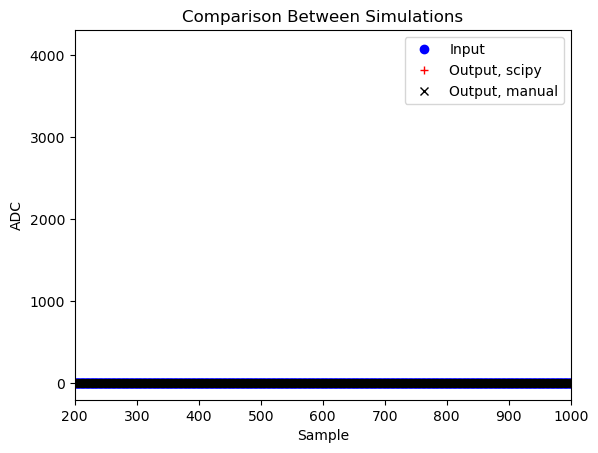

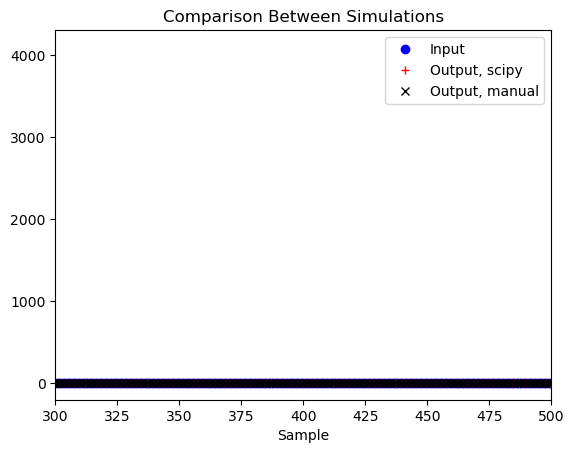

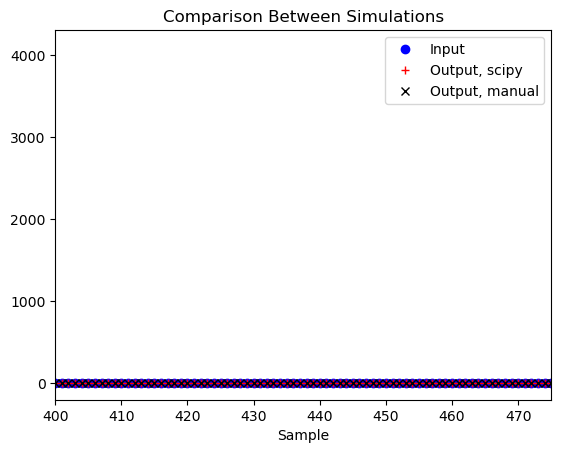

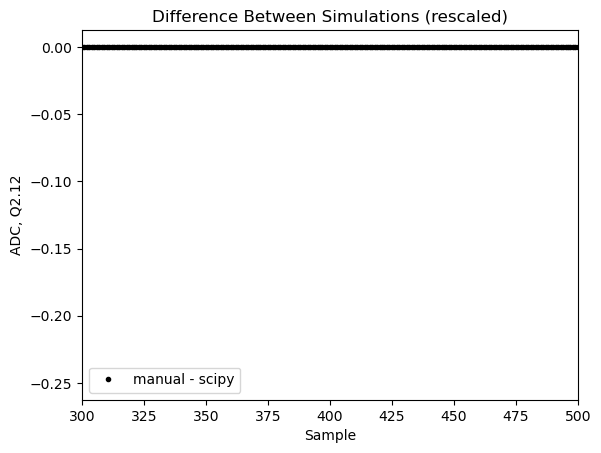

In [127]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,0.5,0.3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
#manual_fir_zero_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):
output0_manual_filtered = manual_fir_section_convert((np.array(zero_coeffs),),input0,
                                                     coeff_int   = 4,
                                                     coeff_frac  = 14,
                                                     data_int    = 17,
                                                     data_frac   = 13,
                                                     out_int     = 14,
                                                     out_frac    = 2)
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.savefig("output.png")
plt.show()

plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


plt.title("Difference Between Simulations (rescaled)")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "manual - scipy", color="k")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC, Q2.12")
plt.legend()
plt.xlim(300,500)
# plt.ylim(-0.15, 0.15)
# plt.savefig("output.png")
plt.show()

# IIR Testing

In [164]:
data = import_data("CaptureData/capture_240912_A_0_B_1_impulse_IIRCoeffs_after_IIR.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]
print(input0_offset)
input0 = input0[input0_offset-8*3:]
input1 = input1[input0_offset-8*3:]
output0 = output0[input0_offset-8*3:]
output1 = output1[input0_offset-8*3:]
print(input0)
# known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay inherent in the z^-1 of the first filter

280
[0 0 0 ... 0 0 0]


In [173]:
known_delay = output0_offset - input0_offset #- 1 # The 1 is from the delay inherent in the z^-1 of the first filter

b: [ 0.93158842 -1.38461023  0.93158842]
a: [ 1.         -1.38461023  0.86317685]
coeffs: [ 1.          1.38461023  1.05396865  0.26417228 -0.54398569 -0.98123555
  1.          1.38461023  1.05396865  0.26417228 -0.54398569 -0.98123555
 -0.88907293  0.76742716 -0.38403967  0.33149415  0.23568191  0.46163755
 -0.38523368  0.33252479 -0.07176094]
[ 0.93158842 -1.38461023  0.93158842]
[ 1.         -1.38461023  0.86317685]
No initial conditions!
F/G FIRs operate on f/g inputs respectively
D_FF: 0.7674271641907793  D_FG: -0.38403966788076954
E_GG: 0.23568191074891445  E_GF: 0.3314941489634413

Update step (matrix) coefficients: [ 0.46163755 -0.38523368  0.33252479 -0.07176094]
As an IIR: (Lucas thinks there is a typo here)
y[0] =-0.3852336759880259*z^-15 + 0.461637549465563*z^-16+F[0]
y[1] =-0.07176093981807906*z^-16 + 0.3325247891146386*z^-17+G[1]


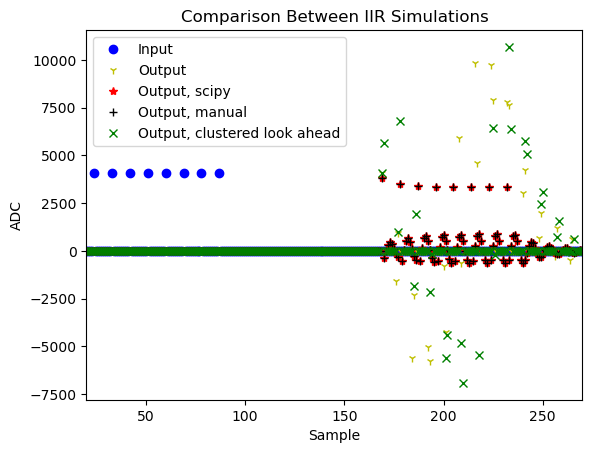

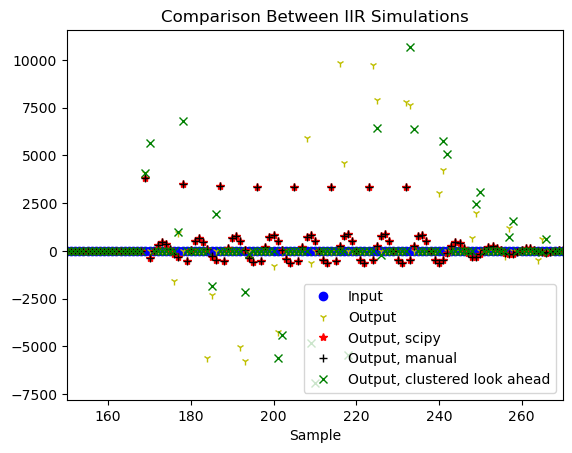

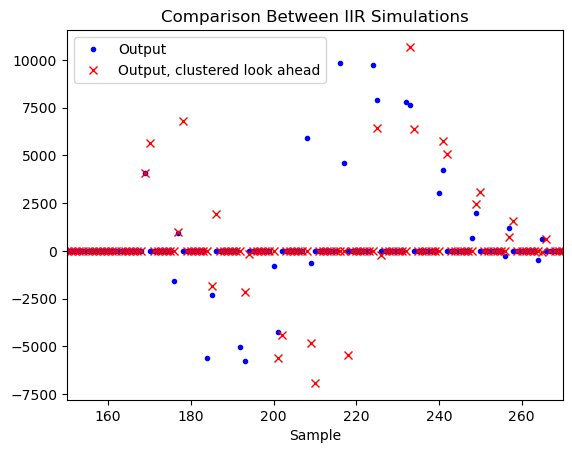

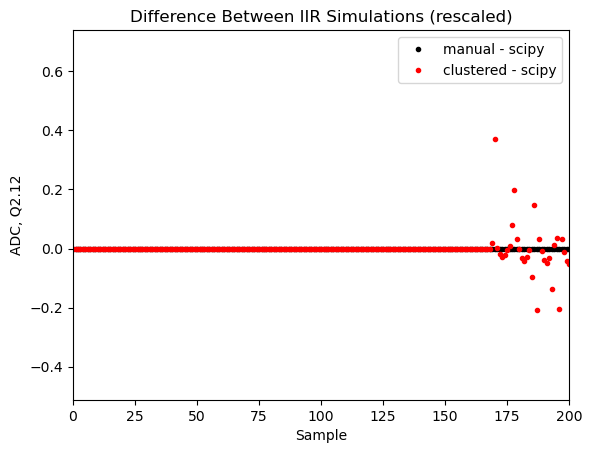

In [175]:
b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
# print(coeffs_returned-coeffs)
print("b: %s"%(b))
print("a: %s"%(a))
print("coeffs: %s"%coeffs)

one_fixed = 16384
zero_coeffs = [1,0,0]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)
pole_fir_coeff = np.array(pole_coeffs, dtype=float)
iir_coeff = np.array(iir_coeffs, dtype=float)

output0_filtered_step1 = lfilter(b, a, input0)
# output0_filtered = lfilter(pole_fir_coeff, iir_coeff, output0_filtered_step1)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered_step1)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
print(b)
print(a)
output0_manual_filtered_stage1 = manual_fir_section_convert((b,),input0,
                                                             coeff_int   = 4,
                                                             coeff_frac  = 14,
                                                             data_int    = 17,
                                                             data_frac   = 13,
                                                             out_int     = 14,
                                                             out_frac    = 2)#*one_fixed*one_fixed/16
output0_manual_filtered = manual_iir_section((a,),output0_manual_filtered_stage1)
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))

output0_manual_filtered2 = iir_biquad_run(input0, coeffs)
output0_manual_filtered2 = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered2)))

plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker="1", label = "Output", color="y")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="*", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="g")
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(20,270)
plt.show()


plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker="1", label = "Output", color="y")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="*", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="g")
plt.xlabel("Sample")
plt.legend()
plt.xlim(150,270)
plt.savefig("output.png")
plt.show()

plt.title("Comparison Between IIR Simulations")
# plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
#          marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="b")
# plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
#          marker="*", label = "Output, scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="r")
plt.xlabel("Sample")
plt.legend()
plt.xlim(150,270)
plt.show()


plt.title("Difference Between IIR Simulations (rescaled)")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "manual - scipy", color="k")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered2 - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "clustered - scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC, Q2.12")
plt.legend()
plt.xlim(0,200)
# plt.ylim(-0.15, 0.15)
plt.savefig("output.png")
plt.show()


# Actual Data

In [151]:
data = import_data("CaptureData/capture_082124_A_0_B_1_impulse_Xall_16384_fg.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]

In [ ]:
plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker=".", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="r")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()

# plt.plot(np.array(range(len(captured_data[1]))), captured_data[1], linestyle="None", 
#          marker=".", label = "In ADC 1")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# plt.title("Post Filter Out")
# plt.plot(np.array(range(len(captured_data[2]))), captured_data[2], linestyle="None", 
#          marker=".", label = "Out DAC 6")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)

# plt.plot(np.array(range(len(captured_data[3]))), captured_data[3], linestyle="None", 
#          marker=".", label = "Out DAC 7")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# Depricated

In [ ]:
np.zeros(8*3).reshape(3,-1)

In [ ]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,2,3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
output0_manual_filtered = manual_fir_zero_section((np.array(zero_coeffs,dtype=int)*one_fixed,),input0)/4#*one_fixed/4
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Zoomed")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.show()

plt.title("Zoomed 2")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


In [ ]:
# Adapted from https://github.com/barawn/pueo-dsp-python/tree/main/dsp. It is not tracked because I don't want to set up a submodule right now
def iir_biquad_update(ins, mag, angle, samp_per_clock=8, ics = None, manual_filter=False):
    if ics is None:
        # Debugging
        print("No initial conditions!")
        ics = np.zeros(samp_per_clock*3)
        ics = ics.reshape(3,-1)

    # Calculate the f and g fir coefficients, using the angle of the notch, the samples
    f_fir = get_f_coeffs(samp_per_clock, mag, angle)
    g_fir = get_g_coeffs(samp_per_clock, mag, angle)

    # Debugging.
    print("Magnitude:", mag, "Angle:", angle)
    print("f/g FIRs are calculated only for sample 0 and sample 1 respectively.")
    print("f FIR:", f_fir)
    print("g FIR:", g_fir)

    # Expand the inputs with the initial conditions
    newins = np.concatenate( (ics[0],ins) )

    # Run the FIRs
    if(manual_filter):
        raise Exception("Not implemented yet")
    else:
        f = signal.lfilter( f_fir, [1], newins )
        g = signal.lfilter( g_fir, [1], newins )
        # Now we decimate f/g by 8, because we only want the 0th and 1st samples out of 8 for each.
    
    f = f.reshape(-1, samp_per_clock).transpose()[0]
    g = g.reshape(-1, samp_per_clock).transpose()[1]
    
    # n.b. f[0]/g[0] are initial conditions

    # Lucas note: I think this should be f[1] and g[1]
    # f[2] (real sample 8) is calculated from 8, 7, 6, 5, 4, 3, 2.
    # g[2] (real sample 9) is calculated from 9, 8, 7, 6, 5, 4, 3, 2.

    # Now we need to compute the F and G functions, which *again* are just FIRs,
    # however they're cross-linked, so it's a little trickier.
    # We split it into
    # F = (fir on f) + G_coeff*g(previous clock)
    # G = (fir on g) + F_coeff*f(previous clock)

    ## D_FF = -1*pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock-2, np.cos(angle)) #L -alpha
    ## E_GG =  pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock, np.cos(angle)) #L delta

    ## # Crosslink coefficients. 
    ## D_FG = pow(mag, samp_per_clock-1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L beta
    ## # Lucas note - This was changed to add a negative sign, better matching the paper
    ## E_GF = -1*pow(mag, samp_per_clock+1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L -gamma

    D_FF, D_FG, E_GF, E_GG = get_F_G_coefficients(samp_per_clock, mag, angle)
    
    F_fir = [ 1.0, D_FF ] # This is for sample 0
    G_fir = [ 1.0, E_GG ] # This is for sample 1

    # Debugging
    print("F/G FIRs operate on f/g inputs respectively")
    print("D_FF:", D_FF, " D_FG:", D_FG)
    print("E_GG:", E_GG, " E_GF:", E_GF)
    print()
    
    # print("F/G FIRs operate on f/g inputs respectively")
    # print("F FIR:", F_fir, "+g*", D_FG)
    # print("G FIR:", G_fir, "-f*", E_GF)
    # print()
    # print("As full FIRs calculated only for sample 0 and 1 respectively:")
    # print("F = f + (fz^-", samp_per_clock, ")+",Coeff_g_in_F,"*(gz^-", samp_per_clock-1, ")",sep='')
    # print("G = g + (gz^-", samp_per_clock, ")+",Coeff_f_in_G,"*(fz^-", samp_per_clock+1, ")",sep='')
        
    # Filter them
    F = signal.lfilter( F_fir, [1], f )
    G = signal.lfilter( G_fir, [1], g )

    # Now we need to feed the f/g paths into the opposite filter
    # F[0]/G[0] are going to be dropped anyway.
    F[1:] += D_FG*g[0:-1]
    G[1:] += E_GF*f[0:-1]    

    # drop the initial conditions
    F = F[1:]
    G = G[1:]
    
    # Now reshape our outputs.
    arr = ins.reshape(-1, samp_per_clock).transpose()
    # arr[0] is now every 0th sample (e.g. for samp_per_clock = 8, it's 0, 8, 16, 24, etc.)
    # arr[1] is now every 1st sample (e.g. for samp_per_clock = 8, it's 1, 9, 17, 25, etc.)

    # IIR parameters. See the 'update step' in paper.
    C = np.zeros(4)
    C[0] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock-2, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    C[1] = pow(mag, 2*samp_per_clock-1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock,np.cos(angle)) -
                                          eval_chebyu(samp_per_clock-2, np.cos(angle))))

    C[2] = pow(mag, 2*samp_per_clock+1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock-2, np.cos(angle))-
                                          eval_chebyu(samp_per_clock, np.cos(angle))))

    C[3] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    # Debugging
    print("Update step (matrix) coefficients:", C)
    print("As an IIR: (Lucas thinks there is a typo here)")
    print("y[0] =", C[1], "*z^-", samp_per_clock*2-1," + ", C[0], "*z^-", samp_per_clock*2,
          "+F[0]",sep='')
    print("y[1] =", C[3], "*z^-", samp_per_clock*2," + ", C[2], "*z^-", samp_per_clock*2+1,
          "+G[1]",sep='')
    # Now compute the IIR.
    # INITIAL CONDITIONS STEP
    y0_0 =  C[0]*ics[1][0] + C[1]*ics[1][1] + F[0]
    y1_0 =  C[2]*ics[1][0] + C[3]*ics[1][1] + G[0]
    y0_1 =  C[0]*ics[2][0] + C[1]*ics[2][1] + F[1]
    y1_1 =  C[2]*ics[2][0] + C[3]*ics[2][1] + G[1]
    for i in range(len(arr[0])):
        if i == 0:
            # Compute from initial conditions.
            arr[0][i] = C[0]*y0_0 + C[1]*y1_0 + F[i]
            arr[1][i] = C[2]*y0_0 + C[3]*y1_0 + G[i]
        elif i==1:
            # Compute from initial conditions
            arr[0][i] = C[0]*y0_1 + C[1]*y1_1 + F[i]
            arr[1][i] = C[2]*y0_1 + C[3]*y1_1 + G[i]
        else:
            # THIS IS THE ONLY RECURSIVE STEP
            arr[0][i] = C[0]*arr[0][i-2] + C[1]*arr[1][i-2] + F[i]
            arr[1][i] = C[2]*arr[0][i-2] + C[3]*arr[1][i-2] + G[i]

        # THIS IS NOT RECURSIVE B/C WE DO NOT TOUCH THE SECOND INDEX
        for j in range(2, samp_per_clock):
            arr[j][i] += 2*mag*np.cos(angle)*arr[j-1][i] - pow(mag, 2)*arr[j-2][i]

    # now transpose arr and flatten
    return arr.transpose().reshape(-1)